<a href="https://colab.research.google.com/github/bharathreddy55/Smart-Queue-Alert-System/blob/main/Smart_Queue_Alert_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Cell 1 — Install dependencies
# Install required Python packages for AWS, image processing, and display.
# Run this cell once at the top of the notebook.

!pip install --quiet boto3 opencv-python-headless pillow numpy matplotlib tqdm
print("✅ Dependencies installed successfully.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00
✅ Dependencies installed successfully.


In [ ]:
# ✅ Cell 2 — Imports + global config
# Imports and the AWS / bucket variables you specified.

import os
import io
import boto3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from getpass import getpass

# AWS SESSION CONFIGURATION WITH SECRET KEY & ACCESS KEY
AWS_REGION = "ap-south-1"
S3_BUCKET = "rekognition-demo-neha"
IAM_USER = "colab-rekognition-user"

# Display config confirmation
print(f"✅ Configured for IAM user: '{IAM_USER}', bucket: '{S3_BUCKET}', region: '{AWS_REGION}'")


✅ Configured for IAM user: 'colab-rekognition-user', bucket: 'rekognition-demo-neha', region: 'ap-south-1'


In [ ]:
# ✅ Cell 3 — Securely input AWS credentials and initialize boto3 clients
# Use getpass so credentials are not shown on-screen.

aws_access_key_id = getpass("🔑 Enter AWS Access Key ID: ")
aws_secret_access_key = getpass("🔒 Enter AWS Secret Access Key: ")

# Create a session and clients
session = boto3.Session(
    aws_access_key_id=aws_access_key_id.strip() or None,
    aws_secret_access_key=aws_secret_access_key.strip() or None,
    region_name=AWS_REGION
)

s3 = session.client("s3")
rek = session.client("rekognition", region_name=AWS_REGION)

# Quick test: list buckets (will raise if creds/permissions wrong)
try:
    buckets = s3.list_buckets()
    print("✅ AWS clients initialized. S3 accessible — found", len(buckets.get("Buckets", [])), "buckets.")
except Exception as e:
    print("❌ Error initializing AWS clients or insufficient permissions:", str(e))
    raise

🔑 Enter AWS Access Key ID: ··········
🔒 Enter AWS Secret Access Key: ··········
✅ AWS clients initialized. S3 accessible — found 8 buckets.


⬆️ Choose an image file to upload (PNG / JPG / JPEG recommended).


Saving WIN_20251108_19_03_32_Pro.jpg to WIN_20251108_19_03_32_Pro.jpg
📤 Uploading 'WIN_20251108_19_03_32_Pro.jpg' to S3 bucket 'rekognition-demo-neha'...
✅ Upload successful!


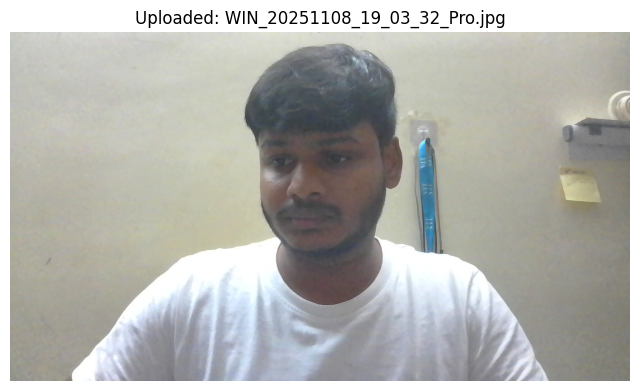

In [ ]:
# ✅ Cell 4 — Upload a local image to your S3 bucket and display it in the notebook.
# This cell uses google.colab.files to pick a file from your local machine.

from google.colab import files
import os

print("⬆️ Choose an image file to upload (PNG / JPG / JPEG recommended).")
uploaded = files.upload()

# Get first uploaded file
filename = list(uploaded.keys())[0]
print(f"📤 Uploading '{filename}' to S3 bucket '{S3_BUCKET}'...")

# Upload to S3
try:
    s3.upload_file(filename, S3_BUCKET, filename)
    print("✅ Upload successful!")
except Exception as e:
    print("❌ Upload failed:", e)
    raise

# Display the uploaded image inline
try:
    img = Image.open(filename).convert("RGB")
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Uploaded: {filename}")
    plt.show()
except Exception as e:
    print("⚠️ Could not display image locally:", e)


In [ ]:
# ✅ Cell 5 — Detect persons in the uploaded image using AWS Rekognition
# Returns the person count and a custom queue alert message.

def detect_persons(bucket, key, min_conf=70.0):
    """
    Detect people in an image stored in S3 and return:
      {
        "count": int,
        "message": str,
        "instances": list of Rekognition bounding box data
      }
    """
    print("🔍 Sending image to Rekognition for person detection...")
    try:
        response = rek.detect_labels(
            Image={"S3Object": {"Bucket": bucket, "Name": key}},
            MaxLabels=50,
            MinConfidence=min_conf
        )
    except Exception as e:
        print("❌ Rekognition call failed:", e)
        raise

    # Extract 'Person' label
    person_label = next((lbl for lbl in response.get("Labels", []) if lbl.get("Name") == "Person"), None)
    instances = person_label.get("Instances", []) if person_label else []
    count = len(instances)

    # Decide message based on count
    if count < 5:
        message = "🍽️ Low queue — go grab your food!"
    elif 5 < count < 11:
        message = "😋 Moderate queue — just a little wait, you can fill your tummy."
    elif count > 11:
        message = "🥵 Crowded — waiting makes the food tasty!"
    else:
        if count == 5:
            message = "🙂 5 people — small queue, might be a short wait."
        else:  # count == 11
            message = "😅 11 people — quite busy, consider waiting a bit."

    # Display summary
    print(f"👥 Detected {count} person(s) with confidence >= {min_conf}%.")
    print("🔔 Alert:", message)

    return {"count": count, "message": message, "instances": instances}


# 🧩 Example usage
image_key = filename  # same image uploaded in Cell 4
result = detect_persons(S3_BUCKET, image_key)

# Display results nicely
print("\n📊 Result Summary:")
print("--------------------")
print(f"Person Count: {result['count']}")
print(f"Queue Alert: {result['message']}")


🔍 Sending image to Rekognition for person detection...
👥 Detected 0 person(s) with confidence >= 70.0%.
🔔 Alert: 🍽️ Low queue — go grab your food!

📊 Result Summary:
--------------------
Person Count: 0
Queue Alert: 🍽️ Low queue — go grab your food!


🔎 Calling Rekognition.detect_faces() ...
👤 Found 1 face(s).


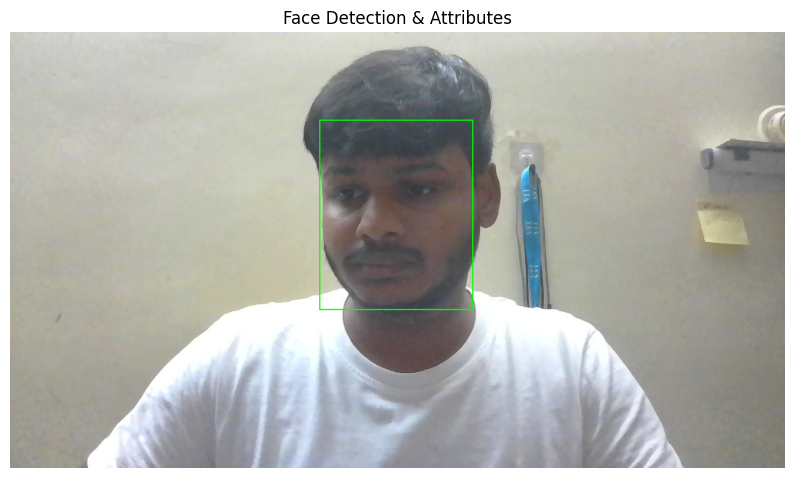

In [ ]:
# ✅ Face detection + overlay (use after uploading image and initializing 'rek', 'filename')
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def detect_and_draw_faces(bucket, key, local_path):
    print("🔎 Calling Rekognition.detect_faces() ...")
    try:
        resp = rek.detect_faces(
            Image={"S3Object": {"Bucket": bucket, "Name": key}},
            Attributes=["ALL"]
        )
    except Exception as e:
        print("❌ Rekognition.detect_faces failed:", e)
        return []

    faces = resp.get("FaceDetails", [])
    print(f"👤 Found {len(faces)} face(s).")
    # open image and draw
    img = Image.open(local_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    # Try to use a reasonably sized default font
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 16)
    except:
        font = ImageFont.load_default()

    for i, f in enumerate(faces):
        b = f.get("BoundingBox", {})
        left = int(b.get("Left", 0) * w)
        top = int(b.get("Top", 0) * h)
        width = int(b.get("Width", 0) * w)
        height = int(b.get("Height", 0) * h)
        right, bottom = left + width, top + height
        draw.rectangle([(left, top), (right, bottom)], outline=(0,255,0), width=3)



    plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Face Detection & Attributes")
    plt.show()

    return faces

# Usage (ensure 'filename' and 'S3_BUCKET' exist)
faces = detect_and_draw_faces(S3_BUCKET, filename, filename)


⚠️ No person instances to draw.


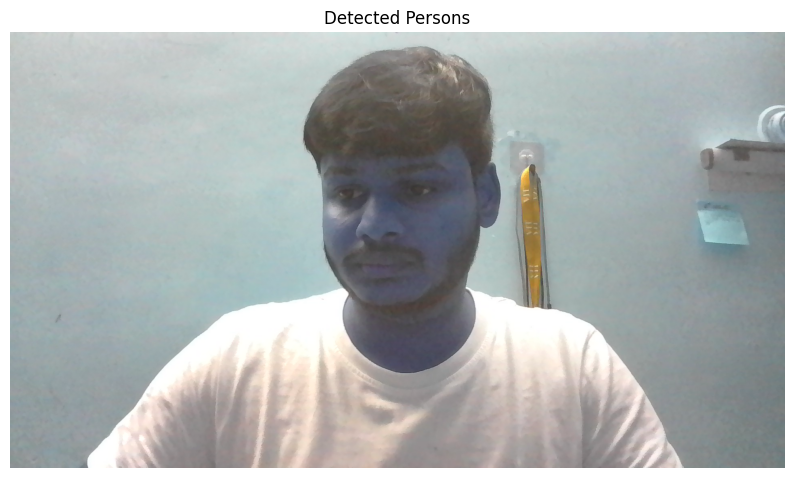

In [ ]:
# ✅ Cell 6 — Draw bounding boxes for detected persons on the local copy and display
# This will annotate and display the image with boxes and labels.

def show_person_boxes(local_image_path, instances):
    img = Image.open(local_image_path).convert("RGB")
    img_np = np.array(img)
    h, w = img_np.shape[:2]

    if not instances:
        print("⚠️ No person instances to draw.")
    for i, inst in enumerate(instances):
        box = inst.get("BoundingBox", {})
        # Rek bounding box values are ratios relative to image size
        left = int(box.get("Left", 0) * w)
        top = int(box.get("Top", 0) * h)
        width = int(box.get("Width", 0) * w)
        height = int(box.get("Height", 0) * h)
        # draw rectangle (BGR for cv2)
        cv2.rectangle(img_np, (left, top), (left + width, top + height), (0, 255, 0), 3)
        cv2.putText(img_np, f"Person {i+1}", (left, max(top-10,0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Convert BGR->RGB for plotting (cv2 uses BGR)
    img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Detected Persons")
    plt.show()

# Draw and show
show_person_boxes(filename, result['instances'])

In [ ]:
# ✅ Cell 7 — Full label detection (objects, scenes, things Rekognition recognizes)
def detect_objects_and_labels(bucket, key, min_conf=50.0):
    print("🧠 Running Rekognition label detection (full scene)...")
    try:
        resp = rek.detect_labels(
            Image={"S3Object": {"Bucket": bucket, "Name": key}},
            MaxLabels=50,
            MinConfidence=min_conf
        )
    except Exception as e:
        print("❌ Rekognition detect_labels failed:", e)
        raise

    labels = resp.get("Labels", [])
    print(f"✅ Detected {len(labels)} labels (min_conf={min_conf}):")
    for lbl in labels:
        name = lbl.get("Name")
        conf = lbl.get("Confidence", 0.0)
        # print top-level label and optionally first few instances or parents
        print(f" - {name} ({conf:.2f}%)")
    return labels

labels = detect_objects_and_labels(S3_BUCKET, image_key, min_conf=60.0)


🧠 Running Rekognition label detection (full scene)...
✅ Detected 26 labels (min_conf=60.0):
 - People (99.99%)
 - Person (99.99%)
 - Adult (99.50%)
 - Female (99.50%)
 - Woman (99.50%)
 - Blazer (99.11%)
 - Clothing (99.11%)
 - Coat (99.11%)
 - Jacket (99.11%)
 - Walking (98.96%)
 - Audience (98.83%)
 - Crowd (98.83%)
 - Indoors (98.83%)
 - Lecture (98.83%)
 - Room (98.83%)
 - Seminar (98.83%)
 - Male (97.40%)
 - Man (97.40%)
 - Accessories (95.05%)
 - Bag (95.05%)
 - Handbag (95.05%)
 - Pants (93.51%)
 - Formal Wear (91.73%)
 - Suit (84.66%)
 - Long Sleeve (67.46%)
 - Sleeve (67.46%)


In [ ]:
# ✅ Cell 8 — List objects in the S3 bucket and show a small table-like printout.

def list_s3_objects(bucket, prefix=None, max_items=100):
    print(f"📦 Listing up to {max_items} objects in bucket '{bucket}' (prefix={prefix})...")
    try:
        kwargs = {"Bucket": bucket, "MaxKeys": max_items}
        if prefix:
            kwargs["Prefix"] = prefix
        resp = s3.list_objects_v2(**kwargs)
    except Exception as e:
        print("❌ Failed to list objects:", e)
        raise

    contents = resp.get("Contents", [])
    if not contents:
        print("⚠️ No files found in bucket.")
        return []

    for obj in contents:
        key = obj.get("Key")
        size = obj.get("Size", 0)
        lastmod = obj.get("LastModified")
        print(f" • {key} — {size} bytes — LastModified: {lastmod}")
    return contents

s3_contents = list_s3_objects(S3_BUCKET)



📦 Listing up to 100 objects in bucket 'rekognition-demo-neha' (prefix=None)...
 • 8 (1).jpeg — 7181 bytes — LastModified: 2025-11-06 02:26:16+00:00


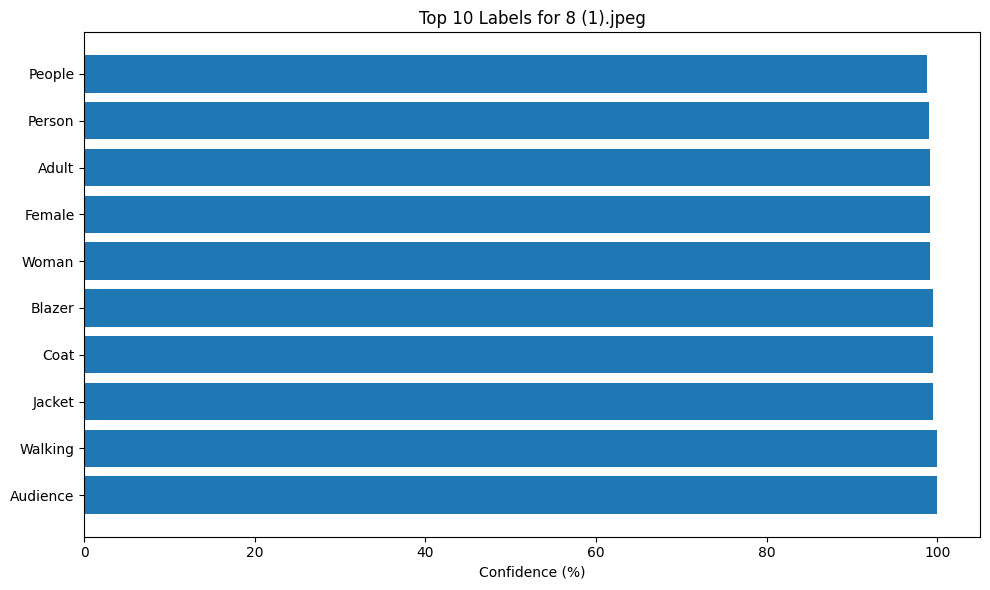

In [ ]:
# ✅ Plot top-10 labels by confidence for a single image (or aggregated)
import matplotlib.pyplot as plt
import numpy as np

def plot_top_labels_for_image(bucket, key, top_n=10, min_conf=10.0):
    resp = rek.detect_labels(Image={"S3Object": {"Bucket": bucket, "Name": key}}, MaxLabels=50, MinConfidence=min_conf)
    labels = resp.get("Labels", [])
    if not labels:
        print("⚠️ No labels found.")
        return
    # sort by Confidence descending
    labels_sorted = sorted(labels, key=lambda x: x.get("Confidence",0), reverse=True)[:top_n]
    names = [l["Name"] for l in labels_sorted]
    confs = [l["Confidence"] for l in labels_sorted]
    plt.figure(figsize=(10,6))
    plt.barh(range(len(names))[::-1], confs[::-1])
    plt.yticks(range(len(names)), names[::-1])
    plt.xlabel("Confidence (%)")
    plt.title(f"Top {len(names)} Labels for {key}")
    plt.tight_layout()
    plt.show()

# Usage
plot_top_labels_for_image(S3_BUCKET, filename, top_n=10, min_conf=50.0)


In [ ]:
# ✅ Batch processing: upload multiple local images, run detection, save annotated images locally and to S3, create pandas DataFrame

import pandas as pd
from google.colab import files
import os

def batch_process_local_images(upload_files=None, min_conf=60.0, s3_output_prefix="outputs/annotated/"):
    """
    upload_files: if None, opens file picker. Otherwise pass list of local file paths.
    """
    if upload_files is None:
        print("⬆️ Select one or more images to upload for batch processing.")
        uploaded = files.upload()
        upload_files = list(uploaded.keys())

    rows = []
    for local in upload_files:
        key = local
        print(f"\n📤✉️ Uploading {local} -> s3://{S3_BUCKET}/{key}")
        s3.upload_file(local, S3_BUCKET, key)
        # detect labels and persons
        labels = rek.detect_labels(Image={"S3Object": {"Bucket": S3_BUCKET, "Name": key}}, MaxLabels=50, MinConfidence=min_conf).get("Labels", [])
        persons = next((l.get("Instances", []) for l in labels if l.get("Name")=="Person"), [])

        # annotate persons locally
        # reuse earlier show_person_boxes style to save annotated file
        annotated_name = f"annotated_{local}"
        from PIL import Image, ImageDraw, ImageFont
        img = Image.open(local).convert("RGB")
        draw = ImageDraw.Draw(img)
        w,h = img.size
        try: font = ImageFont.truetype("DejaVuSans.ttf", 16)
        except: font = ImageFont.load_default()
        for i, inst in enumerate(persons):
            box = inst.get("BoundingBox",{})
            left = int(box.get("Left",0)*w)
            top = int(box.get("Top",0)*h)
            width = int(box.get("Width",0)*w)
            height = int(box.get("Height",0)*h)
            draw.rectangle([(left,top),(left+width, top+height)], outline=(0,255,0), width=3)
            draw.text((left, max(top-18,0)), f"Person {i+1}", fill=(255,255,255), font=font)
        img.save(annotated_name)


        # upload annotated to S3
        s3_key_out = s3_output_prefix + annotated_name
        s3.upload_file(annotated_name, S3_BUCKET, s3_key_out)
        print(f"✅✅ Annotated image uploaded to s3://{S3_BUCKET}/{s3_key_out}")
        # collate metadata for DataFrame
        row = {
            "filename": local,
            "s3_key": key,
            "num_persons": len(persons),
            "num_labels": len(labels),
            "annotated_s3_key": s3_key_out
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    print("\n🫠🫠🫠 Batch processing results:")
    display(df)
    return df

# Usage: run and select files in Colab file picker
batch_df = batch_process_local_images()


⬆️ Select one or more images to upload for batch processing.


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Batch process local images: upload them to S3, detect people, annotate locally, and return a pandas DataFrame.
import pandas as pd
from google.colab import files
from PIL import Image, ImageDraw
import os

def get_person_instances_from_s3(bucket, key, min_conf=70.0):
    """
    Detect people in an image stored in S3 and return a list of bounding box instances.
    """
    try:
        response = rek.detect_labels(
            Image={"S3Object": {"Bucket": bucket, "Name": key}},
            MaxLabels=50,
            MinConfidence=min_conf
        )
    except Exception as e:
        print(f"❌ Rekognition call failed for s3://{bucket}/{key}: {e}")
        return []

    # Extract 'Person' label instances
    person_label = next((lbl for lbl in response.get("Labels", []) if lbl.get("Name") == "Person"), None)
    instances = person_label.get("Instances", []) if person_label else []
    return instances


def batch_process_local_and_detect_people(min_conf=60.0, s3_output_prefix="outputs/annotated/"):
    """
    1) Opens Colab file picker to select multiple images
    2) Uploads each to S3 using the local filename as object key
    3) Calls Rekognition to detect Person instances
    4) Saves an annotated local image (annotated_<filename>) and uploads to S3 under s3_output_prefix
    5) Returns a pandas DataFrame with results
    """
    print("⬆️ Select one or more images to upload for batch processing...")
    uploaded = files.upload()
    local_files = list(uploaded.keys())
    results = []

    for local in local_files:
        key = local
        print(f"\n📤 Uploading {local} -> s3://{S3_BUCKET}/{key}")
        try:
            s3.upload_file(local, S3_BUCKET, key)
        except Exception as e:
            print(f"❌ Failed uploading {local} to S3: {e}")
            continue

        # get person instances
        instances = get_person_instances_from_s3(S3_BUCKET, key, min_conf=min_conf)
        num_persons = len(instances)
        print(f"👥 {local}: detected {num_persons} person(s)")

        # Annotate locally
        try:
            img = Image.open(local).convert("RGB")
            draw = ImageDraw.Draw(img)
            w,h = img.size
            for i, inst in enumerate(instances):
                bb = inst.get("BoundingBox", {})
                left = int(bb.get("Left", 0)*w)
                top = int(bb.get("Top", 0)*h)
                width = int(bb.get("Width", 0)*w)
                height = int(bb.get("Height", 0)*h)
                draw.rectangle([left, top, left+width, top+height], outline=(0,255,0), width=3)
                draw.text((left, max(top-12,0)), f"P{i+1}", fill=(255,255,255))
            annotated_name = f"annotated_{local}"
            img.save(annotated_name)
            # upload annotated to S3
            s3_out_key = s3_output_prefix + annotated_name
            s3.upload_file(annotated_name, S3_BUCKET, s3_out_key)
            print(f"✅ Annotated image uploaded to s3://{S3_BUCKET}/{s3_out_key}")
        except Exception as e:
            print(f"⚠️ Annotation/upload failed for {local}: {e}")
            s3_out_key = None

        results.append({
            "filename": local,
            "s3_key": key,
            "num_persons": num_persons,
            "annotated_s3_key": s3_out_key
        })

    df = pd.DataFrame(results)
    if df.empty:
        print("⚠️ No images processed.")
    else:
        display(df)
    return df

# Usage: run and select files in the picker
batch_df = batch_process_local_and_detect_people(min_conf=60.0)

⬆️ Select one or more images to upload for batch processing...


Saving 8.jpeg to 8 (3).jpeg
Saving 11.jpeg to 11 (2).jpeg
Saving 18.jpeg to 18 (2).jpeg

📤 Uploading 8 (3).jpeg -> s3://rekognition-demo-neha/8 (3).jpeg
👥 8 (3).jpeg: detected 5 person(s)
✅ Annotated image uploaded to s3://rekognition-demo-neha/outputs/annotated/annotated_8 (3).jpeg

📤 Uploading 11 (2).jpeg -> s3://rekognition-demo-neha/11 (2).jpeg
👥 11 (2).jpeg: detected 11 person(s)
✅ Annotated image uploaded to s3://rekognition-demo-neha/outputs/annotated/annotated_11 (2).jpeg

📤 Uploading 18 (2).jpeg -> s3://rekognition-demo-neha/18 (2).jpeg
👥 18 (2).jpeg: detected 14 person(s)
✅ Annotated image uploaded to s3://rekognition-demo-neha/outputs/annotated/annotated_18 (2).jpeg


,filename,s3_key,num_persons,annotated_s3_key
0,8 (3).jpeg,8 (3).jpeg,5,outputs/annotated/annotated_8 (3).jpeg
1,11 (2).jpeg,11 (2).jpeg,11,outputs/annotated/annotated_11 (2).jpeg
2,18 (2).jpeg,18 (2).jpeg,14,outputs/annotated/annotated_18 (2).jpeg


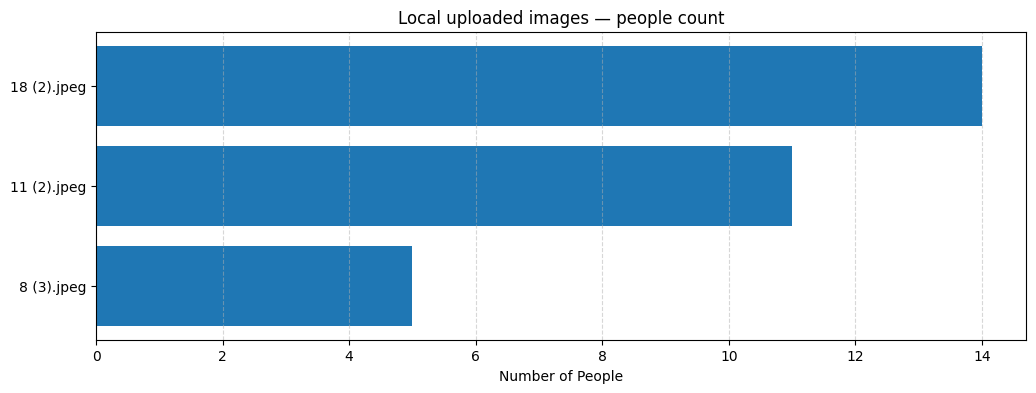

In [ ]:
# Plot a bar chart comparing number of people in each image
import matplotlib.pyplot as plt
import numpy as np

def plot_people_counts(df, title="People detected per image", top_n=None):
    """
    df must have columns: 's3_key' or 'filename' and 'num_persons'
    """
    if df is None or df.empty:
        print("⚠️ No data to plot.")
        return
    plot_df = df.copy()
    # choose label column
    label_col = "filename" if "filename" in plot_df.columns else "s3_key"
    plot_df["label_short"] = plot_df[label_col].apply(lambda v: v.split("/")[-1])
    if top_n:
        plot_df = plot_df.sort_values("num_persons", ascending=False).head(top_n)
    else:
        plot_df = plot_df.sort_values("num_persons", ascending=False)

    names = list(plot_df["label_short"])
    counts = list(plot_df["num_persons"])

    plt.figure(figsize=(12, max(4, len(names)*0.4)))
    y_pos = np.arange(len(names))
    plt.barh(y_pos, counts[::-1])  # reverse for descending visual
    plt.yticks(y_pos, names[::-1])
    plt.xlabel("Number of People")
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

# Usage: choose DataFrame
if 'batch_df' in globals() and not batch_df.empty:
    plot_people_counts(batch_df, title="Local uploaded images — people count")
elif 's3_df' in globals() and not s3_df.empty:
    plot_people_counts(s3_df, title="S3 images — people count")
else:
    print("ℹ️ No processed DataFrame found yet. Run batch processing first.")

In [ ]:
# Batch process images already present in S3 under a prefix (e.g. 'input_images/' or root '').
# It lists objects in the prefix, filters for common image extensions, and runs detection.

import pandas as pd

def batch_process_s3_prefix(prefix="", max_keys=1000, min_conf=60.0):
    """
    prefix : S3 prefix (folder). Use "" to scan whole bucket (be cautious).
    Returns DataFrame with columns: s3_key, num_persons
    """
    print(f"📦 Listing up to {max_keys} objects in s3://{S3_BUCKET}/{prefix}")
    resp = s3.list_objects_v2(Bucket=S3_BUCKET, Prefix=prefix, MaxKeys=max_keys)
    contents = resp.get("Contents", [])
    img_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp")

    results = []
    for obj in contents:
        key = obj.get("Key")
        if not key:
            continue
        if not key.lower().endswith(img_exts):
            continue
        print(f"\n🔁 Processing s3://{S3_BUCKET}/{key}")
        instances = get_person_instances_from_s3(S3_BUCKET, key, min_conf=min_conf)
        num_persons = len(instances)
        print(f"👥 {key}: {num_persons} person(s)")
        results.append({"s3_key": key, "num_persons": num_persons})

    df = pd.DataFrame(results).sort_values("num_persons", ascending=False).reset_index(drop=True)
    if df.empty:
        print("⚠️ No image files found under the specified prefix.")
    else:
        display(df)
    return df

# Usage example (scan bucket root or a subfolder)
s3_df = batch_process_s3_prefix(prefix="", max_keys=500, min_conf=60.0)


📦 Listing up to 500 objects in s3://rekognition-demo-neha/

🔁 Processing s3://rekognition-demo-neha/11 (2).jpeg
👥 11 (2).jpeg: 11 person(s)

🔁 Processing s3://rekognition-demo-neha/11.jpeg
👥 11.jpeg: 11 person(s)

🔁 Processing s3://rekognition-demo-neha/18 (2).jpeg
👥 18 (2).jpeg: 14 person(s)

🔁 Processing s3://rekognition-demo-neha/18.jpeg
👥 18.jpeg: 14 person(s)

🔁 Processing s3://rekognition-demo-neha/8 (1).jpeg
👥 8 (1).jpeg: 5 person(s)

🔁 Processing s3://rekognition-demo-neha/8 (2).jpeg
👥 8 (2).jpeg: 5 person(s)

🔁 Processing s3://rekognition-demo-neha/8 (3).jpeg
👥 8 (3).jpeg: 5 person(s)

🔁 Processing s3://rekognition-demo-neha/outputs/annotated/annotated_11 (2).jpeg
👥 outputs/annotated/annotated_11 (2).jpeg: 7 person(s)

🔁 Processing s3://rekognition-demo-neha/outputs/annotated/annotated_11.jpeg
👥 outputs/annotated/annotated_11.jpeg: 7 person(s)

🔁 Processing s3://rekognition-demo-neha/outputs/annotated/annotated_18 (2).jpeg
👥 outputs/annotated/annotated_18 (2).jpeg: 6 person(s)

,s3_key,num_persons
0,18.jpeg,14
1,18 (2).jpeg,14
2,11.jpeg,11
3,11 (2).jpeg,11
4,outputs/annotated/annotated_11 (2).jpeg,7
5,outputs/annotated/annotated_11.jpeg,7
6,outputs/annotated/annotated_18.jpeg,7
7,outputs/annotated/annotated_18 (2).jpeg,6
8,8 (3).jpeg,5
9,8 (2).jpeg,5


In [ ]:
# Alert mapping function and applying it to a DataFrame with 'num_persons' column

def queue_alert_message(count):
    """
    Your custom alert rules:
    - count < 5 : "low queue go grab your food"
    - 5 <= count <= 10 : "moderate queue just a little wait u can fill ur tummy"
    - count >= 11 : "crowded waiting makes the food tasty"
    """
    try:
        c = int(count)
    except:
        return "Unknown count"

    if c < 5:
        return "Low queue — go grab your food fast 🍽️"
    elif 5 <= c <= 10:
        return "Moderate queue — just a little wait, you can fill your tummy 😊"
    else:
        return "Crowded — waiting makes the food tasty 😋"

# Apply to DataFrame (works for both batch_df and s3_df)
def apply_alerts(df, count_col="num_persons"):
    if df is None or df.empty:
        print("⚠️ DataFrame is empty.")
        return df
    df = df.copy()
    df["alert_message"] = df[count_col].apply(queue_alert_message)
    # Print alerts in readable format
    for _, row in df.iterrows():
        print(f"{row.get('filename') or row.get('s3_key')}: {int(row[count_col])} person(s) -> {row['alert_message']}")
    display(df)
    return df

# Usage examples
if 'batch_df' in globals():
    batch_df_with_alerts = apply_alerts(batch_df)
if 's3_df' in globals():
    s3_df_with_alerts = apply_alerts(s3_df)


8 (3).jpeg: 5 person(s) -> Moderate queue — just a little wait, you can fill your tummy 😊
11 (2).jpeg: 11 person(s) -> Crowded — waiting makes the food tasty 😋
18 (2).jpeg: 14 person(s) -> Crowded — waiting makes the food tasty 😋


,filename,s3_key,num_persons,annotated_s3_key,alert_message
0,8 (3).jpeg,8 (3).jpeg,5,outputs/annotated/annotated_8 (3).jpeg,"Moderate queue — just a little wait, you can f..."
1,11 (2).jpeg,11 (2).jpeg,11,outputs/annotated/annotated_11 (2).jpeg,Crowded — waiting makes the food tasty 😋
2,18 (2).jpeg,18 (2).jpeg,14,outputs/annotated/annotated_18 (2).jpeg,Crowded — waiting makes the food tasty 😋


18.jpeg: 14 person(s) -> Crowded — waiting makes the food tasty 😋
18 (2).jpeg: 14 person(s) -> Crowded — waiting makes the food tasty 😋
11.jpeg: 11 person(s) -> Crowded — waiting makes the food tasty 😋
11 (2).jpeg: 11 person(s) -> Crowded — waiting makes the food tasty 😋
outputs/annotated/annotated_11 (2).jpeg: 7 person(s) -> Moderate queue — just a little wait, you can fill your tummy 😊
outputs/annotated/annotated_11.jpeg: 7 person(s) -> Moderate queue — just a little wait, you can fill your tummy 😊
outputs/annotated/annotated_18.jpeg: 7 person(s) -> Moderate queue — just a little wait, you can fill your tummy 😊
outputs/annotated/annotated_18 (2).jpeg: 6 person(s) -> Moderate queue — just a little wait, you can fill your tummy 😊
8 (3).jpeg: 5 person(s) -> Moderate queue — just a little wait, you can fill your tummy 😊
8 (2).jpeg: 5 person(s) -> Moderate queue — just a little wait, you can fill your tummy 😊
8 (1).jpeg: 5 person(s) -> Moderate queue — just a little wait, you can fill you

,s3_key,num_persons,alert_message
0,18.jpeg,14,Crowded — waiting makes the food tasty 😋
1,18 (2).jpeg,14,Crowded — waiting makes the food tasty 😋
2,11.jpeg,11,Crowded — waiting makes the food tasty 😋
3,11 (2).jpeg,11,Crowded — waiting makes the food tasty 😋
4,outputs/annotated/annotated_11 (2).jpeg,7,"Moderate queue — just a little wait, you can f..."
5,outputs/annotated/annotated_11.jpeg,7,"Moderate queue — just a little wait, you can f..."
6,outputs/annotated/annotated_18.jpeg,7,"Moderate queue — just a little wait, you can f..."
7,outputs/annotated/annotated_18 (2).jpeg,6,"Moderate queue — just a little wait, you can f..."
8,8 (3).jpeg,5,"Moderate queue — just a little wait, you can f..."
9,8 (2).jpeg,5,"Moderate queue — just a little wait, you can f..."


In [ ]:
# ✅ Accuracy & Precision evaluation using the 2 most recent uploads in your S3 bucket
# NOTE: This cell only displays Accuracy and Precision metrics.

import numpy as np
from datetime import datetime

# Helper: classify queue category based on number of people
def queue_class(count):
    """Map person count to queue class label."""
    if count < 5:
        return "low"
    elif 5 <= count <= 10:
        return "moderate"
    else:
        return "crowded"

# Helper: get person count from S3 image
def get_person_count(bucket, key, min_conf=70.0):
    """
    Detect people in an image stored in S3 and return the count.
    Uses the get_person_instances_from_s3 function defined elsewhere.
    """
    instances = get_person_instances_from_s3(bucket, key, min_conf=min_conf)
    return len(instances)


# Step 1 — Get 2 most recent images
resp = s3.list_objects_v2(Bucket=S3_BUCKET, MaxKeys=1000)
img_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp")
images = [obj for obj in resp.get("Contents", []) if obj["Key"].lower().endswith(img_exts)]
images = sorted(images, key=lambda x: x["LastModified"], reverse=True)[:2]

if not images:
    print("⚠️ No image files found in bucket.")
else:
    y_true, y_pred = [], []

    print("🧮 Evaluating accuracy & precision on recent 2 uploads...\n")

    for i, img in enumerate(images):
        key = img["Key"]
        print(f"📷 Image {i+1}: {key}")

        pred_count = get_person_count(S3_BUCKET, key)
        pred_class = queue_class(pred_count)
        print(f"🤖 Predicted: {pred_count} person(s) → class '{pred_class}'")

        while True:
            try:
                gt = int(input(f"🔎 Enter ground-truth person count for '{key}': "))
                break
            except:
                print("Please enter a valid integer.")
        gt_class = queue_class(gt)
        print(f"✅ Ground Truth class: '{gt_class}'\n")

        y_true.append(gt_class)
        y_pred.append(pred_class)

    # Step 2 — Compute Accuracy & Precision
    classes = ["low", "moderate", "crowded"]

    accuracy = sum(1 for p, t in zip(y_pred, y_true) if p == t) / len(y_true)
    print("📊 Results Summary")
    print("------------------")
    print(f"✅ Overall Accuracy: {accuracy * 100:.2f}%")

    # Compute per-class precision
    for cls in classes:
        tp = sum(1 for p, t in zip(y_pred, y_true) if p == cls and t == cls)
        fp = sum(1 for p, t in zip(y_pred, y_true) if p == cls and t != cls)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        print(f"🎯 Precision ({cls.title()} queue): {precision * 100:.2f}%")

    print("\n📈 Evaluation complete — simple accuracy and precision for last 2 uploads shown above.")

🧮 Evaluating accuracy & precision on recent 2 uploads...

📷 Image 1: 18 (2).jpeg
🤖 Predicted: 9 person(s) → class 'moderate'
🔎 Enter ground-truth person count for '18 (2).jpeg': 18
✅ Ground Truth class: 'crowded'

📷 Image 2: outputs/annotated/annotated_11 (2).jpeg
🤖 Predicted: 4 person(s) → class 'low'
🔎 Enter ground-truth person count for 'outputs/annotated/annotated_11 (2).jpeg': 11
✅ Ground Truth class: 'crowded'

📊 Results Summary
------------------
✅ Overall Accuracy: 0.00%
🎯 Precision (Low queue): 0.00%
🎯 Precision (Moderate queue): 0.00%
🎯 Precision (Crowded queue): 0.00%

📈 Evaluation complete — simple accuracy and precision for last 2 uploads shown above.
